In [2]:
import pandas as pd
import time
from datetime import datetime
import random
import urllib
import sqlalchemy
import matplotlib.pyplot as plt
import sys

position = {}
remaining_cash = 1000000.00
loss = 0
win = 0
total_valuation = 0    
profit = 0

In [3]:
params = urllib.parse.quote("DRIVER={ODBC Driver 13 for SQL Server};SERVER=DESKTOP-LSM7IMP\SQLEXPRESS;DATABASE=StocksDMW;Trusted_Connection=yes")
engine = sqlalchemy.create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = """
    select distinct(name) from stockdatadaily 
    order by name
    """
symbol_list = pd.read_sql(sql,engine)['name'].tolist()


In [3]:
sql1= """
select * from stockdatadaily where name ='AMZN'
"""
data = pd.read_sql(sql1,engine)


In [4]:
sql1= """
select * from stockdatadaily where name ='AMZN'
"""
data = pd.read_sql(sql1,engine)


%matplotlib notebook
class Tester():    
    bought = None
    support = None
    support_date = None
    resistance = None
    resistance_date = None
    stop_order = 0.0
    times_bought = 0 
    symbol = None
    
    def automatic_trading(self, data):
        self.symbol = data['Name'].values[0]
        global position
        global remaining_cash
        global loss
        global win
        global total_valuation
        global profit
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data.set_index('date', inplace=True)
        plt.plot(data['2. high'])
        plt.plot(data['3. low'])
        data = data.reset_index()
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        
        for date in data['date']:
            data_till_date = self.data_extract(data, date)

            
            if len(data_till_date) == 1:
                continue
            
            if self.bought == None:
                
                if self.resist_condition(data_till_date):
                    self.resistance, self.resistance_date = self.resistance_cal(data_till_date)
                    plt.scatter(date, self.resistance, color = 'b', marker='*', label = "Resistance")
                else:
                    pass
                
                if self.resistance != None and self.support_condition(data_till_date, self.resistance):
                    self.support = self.support_cal(self.resistance_date,data_till_date)
                    plt.scatter(date, self.support, color = 'r', marker = 'o', label = "Support")
                
                if self.support != None and self.resistance != None and self.buy_condition(self.resistance, data_till_date):
                    
                    today_row_data = data_till_date.tail(1)
                    self.bought = today_row_data['2. high'].values[0]
                    self.stop_order = self.support * 0.97
                    
                    quantity = (remaining_cash * 0.02) // self.bought
                    remaining_cash = remaining_cash * 0.98
                    position.update({today_row_data['Name'].values[0]: quantity})
                    print("Buying--->", "Date::",date)
                    print("bought at : ", self.bought, "stop_order:", self.stop_order, "current_price", self.bought, "resistance:", self.resistance)
                    print("Place order: ", today_row_data['Name'].values[0])
                    print("Balance:", remaining_cash)
                    print("\n")
            
            else:
                today_price = data_till_date.tail(1)['2. high'].values[0]
                if self.stop_order > today_price:
                    self.stop_order = None
                    print("Selling ---> ", date)
                    print("Today Price: ", today_price)
                    sold = today_price * position[self.symbol]
                    del position[self.symbol]
                    self.bought = None
                else:
                    if self.resist_condition(data_till_date):
                        self.resistance, self.resistance_date = self.resistance_cal(data_till_date)
                        plt.scatter(self.resistance_date, self.resistance, label="Resistance")
                    if self.resistance and self.support_condition(data_till_date, self.resistance):
                        self.support = self.support_cal(self.resistance_date, data_till_date)
                        plt.scatter(date, self.support, color = 'r', marker = 'o', label = "Support" )
                    if self.resistance != None and self.support != None and self.buy_condition(self.resistance, data_till_date):
                        self.stop_order = self.support * 0.97
                        plt.scatter(date, self.stop_order, marker = 'o', color = 'green', label = "Stop Order")
        
                    
                
                    
                    
                    
                
                    

                    
        
      
        plt.legend()
        plt.show()
        print("Position:" , position)
        
    def resistance_cal(self, data_resistance):
        start_time = time.time()
        highest_data = data_resistance[data_resistance['2. high'] == max(data_resistance['2. high'])]
        date = highest_data['date'].values[0]
        resistance = highest_data['2. high'].values[0]
        
        print("Resistance Calculation ", time.time() - start_time)
        return round(resistance,2), date                
                
    def support_cal(self, resist_date, data_support):
        start_time = time.time()
        # data since the last resistance date until today's date.
        data_since_last_resistance = data_support.loc[data_support['date'] >= resist_date]
        # data variable here contains the row of the dataframe with the lowest value of '3. low' values
        data = data_since_last_resistance.loc[data_since_last_resistance['3. low']==min(data_since_last_resistance['3. low'])]
        # support here contains the lowest value of stock since last resistance date
        support = data['3. low'].values[0]
        print("Support Calculation ", time.time() - start_time)

        # we return the support value and the date of the support value
        return support
    
    def resist_condition(self,data_resistance):
        start_time = time.time()
        recent_data = data_resistance.tail(2)   # Getting yesterday's and today's price
        yesterday_price = recent_data['3. low'].values[0]   # Yesterday's prices
        today_price = recent_data['3. low'].values[1]       # today's prices  
        
        print("Resistance condition ", time.time() - start_time)
        if(today_price < yesterday_price):
            return True
        else:
            return False
        # If today's lowest price of the stock is less than yesterday's lowest price of the stock,
        # then Resistance condition is met
    
    def support_condition(self, data_support, resist_passed):
        current_price = data_support.tail(1)['2. high'].values[0] # Today's price of the stock
        if(current_price > resist_passed):
            return True
        else:
            return False
        #If the current price of the stock is greater than the current resistance value that is passed then,
        # the support condition is met     
        
    def buy_condition(self, resist, data):
        if resist < data.tail(1)['2. high'].values[0]:
            return True
        else:
            return False       
    
    def data_extract(self,data, *args):
        if len(args) == 2:
            data = data.loc[data['date'] >= args[0]]
            data = data.loc[data['date'] <= args[1]]
        else:
            data = data.loc[data['date'] <= args[0]]
        return data
    


<IPython.core.display.Javascript object>


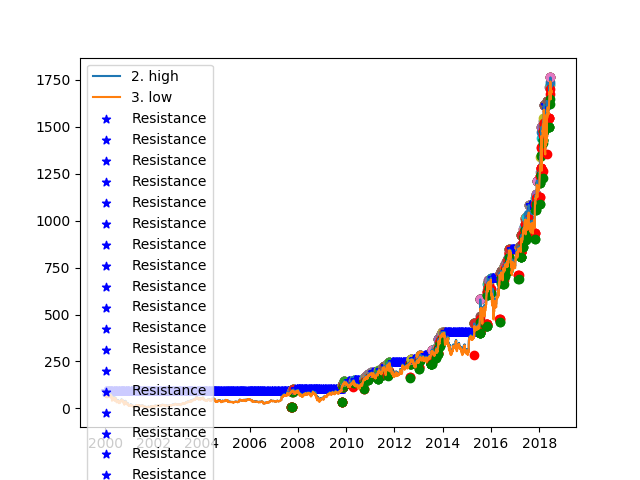

Resistance condition  0.0010044574737548828
Resistance condition  0.00099945068359375
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0009987354278564453
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0010006427764892578
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.000997781753540039
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0010004043579101562
Resistance Calculation  0.000997781753540039
Resistance condition  0.0009822845458984375
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0010004043579101562
Resistance condition  0.00099611

Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0010008811950683594
Resistance condition  0.0
Resistance Calculation  0.0009987354278564453
Resistance condition  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0020055770874023438
Resistance Calculation  0.000993490219116211
Resistance condition  0.0
Resistance Calculation  0.0009987354278564453
Resistance condition  0.0009996891021728516
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.0009999275207519531
Resistance condition  0.0009984970092773438
Resistance Calculation  0.0010001659393310547
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.002997159957885742
Resistance condition  0.0009999275207519531
Resistance Calculation  0.0
Resistance condition  0.0
Resistan

Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0009992122650146484
Resistance Calculation  0.0
Resistance condition  0.00099945068359375
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0009846687316894531
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0010001659393310547
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.000997781753540039
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance Calculation  0.0009982585906982422
Resistance condition  0.0009992122650146484
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Res

Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0019986629486083984
Resistance condition  0.0
Resistance condition  0.0009996891021728516
Resistance Calculation  0.0009980201721191406
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance condition  0.0010004043579101562
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance condition  0.00099945068359375
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance condition  0.0009992122650146484
Resistance condition  0.0009982585906982422
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.00099992

Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009944438934326172
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0010006427764892578
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0010001659393310547
Resistance condition  0.0
Resistance condition  0.0010006427764892578
Resistance Calculation  0.0010001659393310547
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0009987354278564453
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009982585906982422
Resistance condition  0.0
Resistance condition  0.0
Resistance Calcula

Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance Calculation  0.0020017623901367188
Resistance condition  0.0
Resistance Calculation  0.0019991397857666016
Resistance condition  0.0
Resistance Calculation  0.0019986629486083984
Resistance condition  0.0
Resistance condition  0.0010001659393310547
Resistance Calculation  0.001996755599975586
Resistance condition  0.0010006427764892578
Resistance Calculation  0.001999378204345703
Resistance condition  0.0
Resistance Calculation  0.0019989013671875
Resistance condition  0.0009989738464355469
Resistance condition  0.0009992122650146484
Resistance Calculation  0.01099252700805664
Resistance condition  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.001998424

Resistance condition  0.001001119613647461
Resistance Calculation  0.001001596450805664
Resistance condition  0.0
Resistance condition  0.0009987354278564453
Resistance condition  0.0010066032409667969
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0010006427764892578
Resistance condition  0.0
Resistance Calculation  0.003996133804321289
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0019991397857666016
Resistance condition  0.00099945068359375
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0009996891021728516
Resistance condition  0.0009992122650146484
Resistance Calculation  0.002000093460083008
Resistance condition  0.0010018348693847656
Resistance Calculation  0.0009920597076416016
Resistance condition  0.0009989738464355469
Resistance condition  0.0
Resistance condition  0.0009918212890625
Resistance Calculation  0.0019989013671875
Resistance condition  0.0
Resistance condi

Resistance Calculation  0.015624523162841797
Resistance condition  0.0
Resistance condition  0.0009987354278564453
Resistance condition  0.0
Resistance Calculation  0.0009987354278564453
Resistance condition  0.0009999275207519531
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0009984970092773438
Resistance condition  0.0
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0010008811950683594
Resistance condition  0.0
Resistance Calculation  0.0009963512420654297
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.0010004043579101562
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculatio

Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0009989738464355469
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0019989013671875
Resistance condition  0.0
Resistance Calculation  0.002001047134399414
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance condition  0.0010175704956054688
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0009982585906982422
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0020008087158203125
Resistance condition  0.0009996891021728516
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0010008811950683594
Resistance Calculation  0.

Resistance Calculation  0.01562356948852539
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0
Resistance Calculation  0.0009982585906982422
Resistance condition  0.0
Resistance Calculation  0.0019979476928710938
Resistance condition  0.0
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.001995086669921875
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0
Resistance Calculation  0.000997781753540039
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.00099945068359375
Resistance Calculation  0.0
Resistance condition  0.000997304916381836
Resistance condition  0.0009992122650146484
Resistance condition  0.0
Resistanc

Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0019986629486083984
Resistance condition  0.0010006427764892578
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009982585906982422
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.002008199691772461
Resistance condition  0.0
Support Calculation  0.0029981136322021484
Resistance condition  0.0
Resistance Calculation  0.0019986629486083984
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.001998424530029297
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0010013580322265625
Resistance Calculation  0.0009975433349609375
Resistance condition  0.0010042190551757812
Resistance Calculation  0.0019905567169189453
Resistance condition  0.0
Resistance Calcul

Resistance condition  0.0010008811950683594
Resistance Calculation  0.002998828887939453
Resistance condition  0.0
Resistance Calculation  0.0019979476928710938
Resistance condition  0.0009992122650146484
Resistance Calculation  0.0019996166229248047
Resistance condition  0.0
Resistance Calculation  0.0019981861114501953
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0010001659393310547
Resistance Calculation  0.003996372222900391
Resistance condition  0.0
Resistance Calculation  0.003997802734375
Resistance condition  0.0010004043579101562
Resistance condition  0.0009891986846923828
Resistance condition  0.0
Resistance condition  0.0010001659393310547
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0019986629486083984
Resistance condition  0.0
Resistance Calculation  0.001994609832763672
Resistance condition  0.0
Resistance condit

Resistance condition  0.0010006427764892578
Resistance condition  0.000997304916381836
Resistance Calculation  0.0010013580322265625
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0020008087158203125
Resistance condition  0.0
Resistance Calculation  0.0019979476928710938
Resistance condition  0.0
Resistance condition  0.00099945068359375
Resistance condition  0.0010006427764892578
Resistance Calculation  0.003003835678100586
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009992122650146484
Resistance condition  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0010001659393310547
Resistance condition  0.0
Resistance Calculation  0.00099849700927

Resistance Calculation  0.0019986629486083984
Resistance condition  0.00099945068359375
Resistance Calculation  0.0019996166229248047
Resistance condition  0.0
Resistance Calculation  0.001998424530029297
Resistance condition  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance condition  0.0010006427764892578
Resistance Calculation  0.0019979476928710938
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.001990079879760742
Resistance condition  0.0009996891021728516
Resistance condition  0.0009984970092773438
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0030050277709960938
Resistance condition  0.0
Resistance Calculation  0.0020017623901367188
Resistance condition  0.0
Resistance Calculation  0.001998

Resistance condition  0.0
Resistance condition  0.000997781753540039
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0010004043579101562
Resistance condition  0.0010006427764892578
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.001999378204345703
Resistance condition  0.0
Resistance condition  0.0010039806365966797
Resistance condition  0.0010001659393310547
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0009951591491699219
Resistance condition  0.0
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0010013580322265625
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0010006427764892578
Resistance condition  0.0009996891021728516
Resistance condition  0.0
Resistance condition

Resistance condition  0.0010004043579101562
Resistance condition  0.0009930133819580078
Resistance condition  0.0
Support Calculation  0.0009996891021728516
Resistance condition  0.0
Support Calculation  0.0019986629486083984
Resistance condition  0.0009992122650146484
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0009996891021728516
Support Calculation  0.001996755599975586
Resistance condition  0.0
Resistance Calculation  0.0019974708557128906
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0009987354278564453
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0003170967102050781
Selling --->  2011-05-25 00:00:00
Today Price:  194.35
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
R

Resistance condition  0.0009992122650146484
Resistance Calculation  0.0029990673065185547
Resistance condition  0.00099945068359375
Resistance Calculation  0.002001523971557617
Resistance condition  0.0
Resistance condition  0.0010001659393310547
Resistance condition  0.0009992122650146484
Resistance condition  0.0
Resistance Calculation  0.001998424530029297
Resistance condition  0.0
Resistance condition  0.0009996891021728516
Resistance Calculation  0.004001617431640625
Resistance condition  0.0
Resistance condition  0.0009980201721191406
Resistance condition  0.0009987354278564453
Resistance condition  0.0009999275207519531
Resistance Calculation  0.0019996166229248047
Resistance condition  0.00099945068359375
Resistance Calculation  0.0029981136322021484
Resistance condition  0.0009999275207519531
Resistance condition  0.0
Resistance condition  0.00099945068359375
Resistance Calculation  0.003999948501586914
Resistance condition  0.0010006427764892578
Resistance Calculation  0.0039

Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0009987354278564453
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0
Resistance Calculation  0.0010008811950683594
Resistance condition  0.0
Resistance condition  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0019996166229248047
Resistance condition  0.0009911060333251953
Resistance Calculation  0.0009925365447998047
Resistance condition  0.0
Resistance Calculation  0.0029969215393066406
Resistance condition  0.0
Resistance Calculation  0.0009984970092773438
Selling --->  2012-10-12 00:00:00
Today Price:  245.46
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0009984970092773438
Resistance Calculat

Resistance condition  0.0
Support Calculation  0.0
Resistance condition  0.0010004043579101562
Support Calculation  0.001999378204345703
Resistance condition  0.0
Resistance Calculation  0.0020017623901367188
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0020012855529785156
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0009999275207519531
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.001001119613647461
Resistance condition  0.0
Resistance Calculation  0.0009999275207519531
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.00099992

Resistance condition  0.0
Resistance Calculation  0.001996278762817383
Resistance condition  0.0010006427764892578
Resistance condition  0.0009984970092773438
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0009992122650146484
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0009915828704833984
Resistance Calculation  0.0009999275207519531
Resistance condition  0.0020024776458740234
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0009989738464355469
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.001016378402709961
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0010001659393310547
Resistance condition  0.00099945068359375
Resistance Calculation  0.0009984970092773438
Resistance condition  0.0
Resistance Calculation  0.004992961883544922
Resistance condition  0.0
Resistance Calculatio

Resistance condition  0.0009970664978027344
Resistance condition  0.0
Resistance condition  0.0009996891021728516
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.002000093460083008
Resistance condition  0.0
Resistance Calculation  0.002000093460083008
Resistance condition  0.0
Resistance condition  0.0009999275207519531
Resistance Calculation  0.0029990673065185547
Resistance condition  0.0
Resistance condition  0.0009992122650146484
Resistance condition  0.0
Resistance condition  0.0009975433349609375
Resistance Calculation  0.001001119613647461
Resistance condition  0.0009984970092773438
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.015625
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0


Resistance condition  0.0
Support Calculation  0.009354352951049805
Resistance condition  0.0
Resistance Calculation  0.0019960403442382812
Resistance condition  0.0
Resistance Calculation  0.0019974708557128906
Resistance condition  0.0
Resistance condition  0.0010039806365966797
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009996891021728516
Resistance condition  0.0
Support Calculation  0.0009996891021728516
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Support Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.01562190055847168
Resistance condition  0.0
Resistance Calculation  0.0
Resistance c

Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0009989738464355469
Resistance condition  0.0
Support Calculation  0.0010001659393310547
Resistance condition  0.0
Resistance Calculation  0.002002239227294922
Resistance condition  0.0
Support Calculation  0.0009992122650146484
Resistance condition  0.0
Resistance Calculation  0.0013499259948730469
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Support Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resist

Resistance condition  0.0009982585906982422
Support Calculation  0.002997159957885742
Resistance condition  0.0
Resistance Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0009965896606445312
Resistance condition  0.0
Resistance Calculation  0.000997304916381836
Resistance condition  0.001001119613647461
Resistance condition  0.0
Support Calculation  0.002986431121826172
Resistance condition  0.0
Resistance Calculation  0.0010085105895996094
Resistance condition  0.000990152359008789
Resistance Calculation  0.0009992122650146484
Resistance condition  0.0
Support Calculation  0.0009996891021728516
Resistance condition  0.0
Support Calculation  0.00099945068359375
Resistance condition  0.0
Support Calculation  0.00099945068359375
Resistance condition  0.0
Resistance Calculation  0.0009982585906982422
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Support Calculation  0.0009965896606445312
Resistance condition  0.0
Support

Resistance condition  0.0019979476928710938
Resistance condition  0.0
Resistance condition  0.00099945068359375
Resistance Calculation  0.0029990673065185547
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Support Calculation  0.0010006427764892578
Resistance condition  0.0
Support Calculation  0.0039975643157958984
Resistance condition  0.0
Support Calculation  0.0020003318786621094
Resistance condition  0.0
Support Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.001999378204345703
Resistance condition  0.0009987354278564453
Support Calculation  0.0009989738464355469
Resistance condition  0.0
Support Calculation  0.0009987354278564453
Resistance condition  0.0
Support Calculation  0.0
Resistance condition  0.0
Resistance Calculation  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Resistance condition  0.0
Support Calculation  0.0
Resistance condition  0.0
Support Calculation  0.0009996891021728516
Re

In [5]:
T = Tester()
T.automatic_trading(data)
print(T.resistance)

In [6]:
sys.getsizeof(data)


782480